<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Simple LD-PLSM Modeling with MLR
</p>

In [2]:
# ================================== Libraries =======================================
import numpy as np                                           # For numerical operations
import pandas as pd                                          # For data manipulation and analysis
import matplotlib.pyplot as plt                              # For plotting and visualizations
import matplotlib.dates as mdates                            # For handling date formatting in plots
import seaborn as sns                                        # For enhanced data visualizations
from sklearn.metrics import mean_squared_error, r2_score     # For model evaluation metrics
from sklearn.model_selection import KFold, train_test_split  # For splitting data and cross-validation
from scipy.optimize import curve_fit                         # For curve fitting and optimization             

In [3]:
# Load the cleaned data by IF into 'df' and display it.
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322171 entries, 0 to 1322170
Data columns (total 20 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   time         1322171 non-null  object 
 1   device_id    1322171 non-null  object 
 2   co2          1322171 non-null  float64
 3   humidity     1322171 non-null  float64
 4   pm25         1322171 non-null  float64
 5   pressure     1322171 non-null  float64
 6   temperature  1322171 non-null  float64
 7   rssi         1322171 non-null  float64
 8   snr          1322171 non-null  float64
 9   SF           1322171 non-null  int64  
 10  frequency    1322171 non-null  float64
 11  f_count      1322171 non-null  float64
 12  p_count      1322171 non-null  float64
 13  toa          1322171 non-null  float64
 14  distance     1322171 non-null  int64  
 15  c_walls      1322171 non-null  int64  
 16  w_walls      1322171 non-null  int64  
 17  exp_pl       1322171 non-null  float64
 18  n_

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Data Preparation and Single Train-Test Split
</p>

In [5]:
# Extract the necessary columns for LDPLM-MW
time_all = df['time'].values
d_all = df['distance'].values
c_walls_all = df['c_walls'].values
w_walls_all = df['w_walls'].values
PL_all = df['exp_pl'].values

# Combine selected features into a single array
selected_features = np.column_stack((
    d_all, c_walls_all, w_walls_all
))

# Perform a single train-test split (80-20 split)
X_train, X_test, PL_train, PL_test, time_train, time_test = train_test_split(
    selected_features, PL_all, time_all, test_size=0.2, random_state=50 )

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Defining LDPLM-MW Model, Fitting, and Extracting Parameters
</p>

In [7]:
# Indices for features used in LDPLM-MW
idx_mw = [0, 1, 2]  # Based on selected_features (d_all, c_walls_all, w_walls_all)

# Extract training and testing data for LDPLM-MW
x_train_mw = X_train[:, idx_mw].T  # Transpose to match original shape
x_test_mw = X_test[:, idx_mw].T
PL_train_mw = PL_train
PL_test_mw = PL_test

# Define the Log-Distance Path Loss Model with Multi-Wall alone
def log_distance_path_loss_separate_walls(x, PL_d0, n, L_c, L_w):
    d, c_walls, w_walls = x
    d0 = 1  # Reference distance in meters
    return (PL_d0 + 10 * n * np.log10(d / d0) + c_walls * L_c + w_walls * L_w)

# Initial guesses for PL_d0, n, L_c, and L_w
initial_guesses_mw = [30, 2, 5, 3]  # These can be adjusted based on prior knowledge

# Perform curve fitting for LDPLM-MW
popt_mw, pcov_mw = curve_fit(
    log_distance_path_loss_separate_walls,
    x_train_mw,
    PL_train_mw,
    p0=initial_guesses_mw,
    maxfev=100000
)

# Extract the fitted parameters for LDPLM-MW
PL_d0_mw, n_mw, L_c_mw, L_w_mw = popt_mw

# Predict path loss for the test set
PL_pred_mw = log_distance_path_loss_separate_walls(x_test_mw, PL_d0_mw, n_mw, L_c_mw, L_w_mw)

# Calculate the shadowing component for the training set
PL_train_pred_mw = log_distance_path_loss_separate_walls(x_train_mw, PL_d0_mw, n_mw, L_c_mw, L_w_mw)
shadowing_train_mw = PL_train_mw - PL_train_pred_mw
sigma_mw = np.std(shadowing_train_mw)

# Calculate RMSE and R-squared for LDPLM-MW on Test Set
rmse_mw = np.sqrt(mean_squared_error(PL_test_mw, PL_pred_mw))
r_squared_mw = r2_score(PL_test_mw, PL_pred_mw)

# Calculate RMSE and R-squared for LDPLM-MW on Training Set
rmse_train_mw = np.sqrt(mean_squared_error(PL_train_mw, PL_train_pred_mw))
r_squared_train_mw = r2_score(PL_train_mw, PL_train_pred_mw)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Parameters and Metrics for the the Model
</p>

In [9]:
# Parameters for LDPLM-MW
params_mw = {
    'PL(d0) [dB]': PL_d0_mw,
    'Path loss exponent (n)': n_mw,
    'Brick Wall Loss (L_c) [dB]': L_c_mw,
    'Wood Wall Loss (L_w) [dB]': L_w_mw
}

# Define the list of parameters
parameter_list = list(params_mw.keys())

# Create the LDPLM-MW column
ldplm_mw_values = list(params_mw.values())

# Construct the DataFrame
params_df = pd.DataFrame({
    'Parameter': parameter_list,
    'LDPLM-MW': ldplm_mw_values
})

print("\n=== Table of LDPLM-MW Parameters ===\n")
display(params_df)

# Metrics for LDPLM-MW
metrics = [
    'RMSE (Train) [dB]', 
    'RMSE (Test) [dB]', 
    'R-squared (Train)', 
    'R-squared (Test)', 
    'Shadowing σ (dB)'
]
metrics_values = {
    'LDPLM-MW': [rmse_train_mw, rmse_mw, r_squared_train_mw, r_squared_mw, sigma_mw]
}

metrics_df = pd.DataFrame(metrics_values, index=metrics)

print("\n=== Performance Metrics for LDPLM-MW ===\n")
display(metrics_df)


=== Table of LDPLM-MW Parameters ===



,Parameter,LDPLM-MW
0,PL(d0) [dB],27.804537
1,Path loss exponent (n),4.085506
2,Brick Wall Loss (L_c) [dB],8.119087
3,Wood Wall Loss (L_w) [dB],1.826818



=== Performance Metrics for LDPLM-MW ===



,LDPLM-MW
RMSE (Train) [dB],11.137233
RMSE (Test) [dB],11.080464
R-squared (Train),0.656596
R-squared (Test),0.659682
Shadowing σ (dB),11.137233


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Plotting some assessement Metrics for the Model
</p>

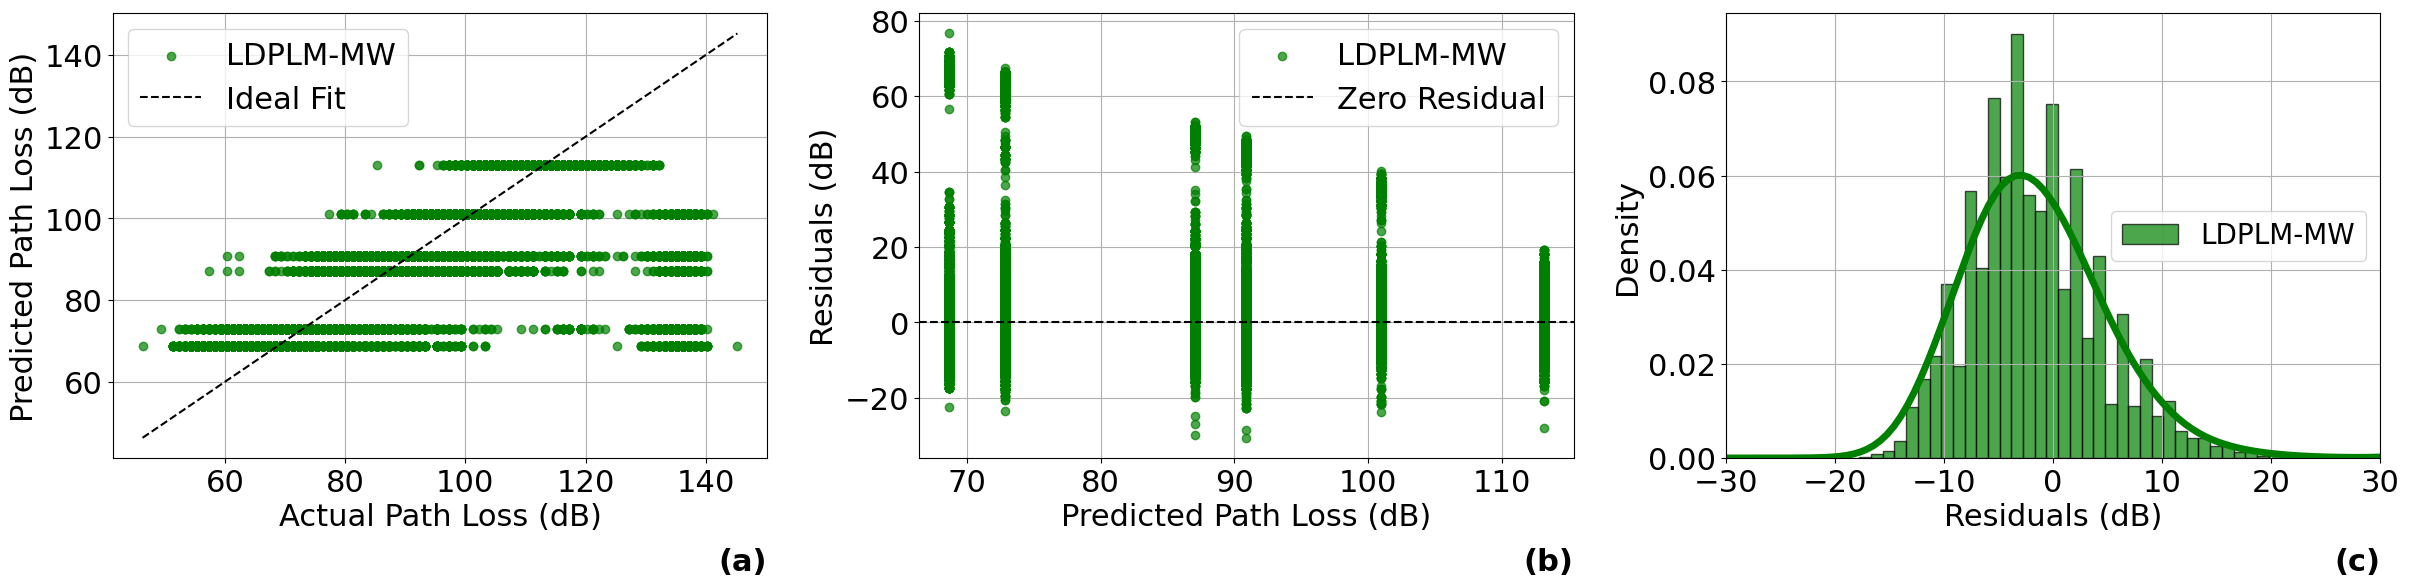


Residual Distribution Values:

LDPLM-MW: Mean: -0.0358 dB, Skewness: 3.5291


In [11]:
# -------------------------------
# Section 4: Plotting
# -------------------------------

# Step 15, 16 & 17: Plot Actual vs Predicted Path Loss, Residual Analysis, and Histogram as Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Step 15: Plot Actual vs Predicted Path Loss on ax1 for LDPLM-MW
ax1.scatter(PL_test_mw, PL_pred_mw, alpha=0.7, label='LDPLM-MW', color='green', zorder=2)
# Ideal Fit Line in black, highest zorder to appear on top
ax1.plot(
    [PL_test_mw.min(), PL_test_mw.max()],
    [PL_test_mw.min(), PL_test_mw.max()],
    'k--', label='Ideal Fit', zorder=3
)
ax1.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax1.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
# ax1.set_title('Actual vs Predicted Path Loss')
ax1.legend(fontsize=22, loc='upper left')
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=22)
ax1.text(1, -0.2, '(a)', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Step 16: Residual Analysis - Residuals vs Predicted Path Loss on ax2 for LDPLM-MW
residuals_mw = PL_test_mw - PL_pred_mw
ax2.scatter(PL_pred_mw, residuals_mw, alpha=0.7, label='LDPLM-MW', color='green', zorder=2)
# Horizontal line at zero in black, highest zorder to appear on top
ax2.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=3)
ax2.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax2.set_ylabel('Residuals (dB)', fontsize=22)
# ax2.set_title('Residuals vs Predicted Path Loss')
ax2.legend(fontsize=22, loc='upper right')
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=22)
ax2.text(1, -0.2, '(b)', transform=ax2.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Step 17: Residual Analysis - Histogram of Residuals on ax3 for LDPLM-MW
# Plot histogram for LDPLM-MW with density normalization
ax3.hist(residuals_mw, bins=100, alpha=0.7, label='LDPLM-MW', color='green', edgecolor='k', density=True)
# KDE plot using Seaborn 
sns.kdeplot(residuals_mw, color='green', bw_adjust=3, ax=ax3, linewidth=5)

ax3.set_xlabel('Residuals (dB)', fontsize=22)
ax3.set_ylabel('Density', fontsize=22)  # Changed from 'Frequency' to 'Density' due to normalization
# ax3.set_title('Histogram of Residuals')
ax3.set_xlim(-30, 30)  # Set x-axis limits
ax3.legend(fontsize=20, loc='center right')
ax3.grid(True)
ax3.tick_params(axis='both', which='major', labelsize=22)
ax3.text(1, -0.2, '(c)', transform=ax3.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Adjust layout to prevent overlapping
plt.tight_layout()
# Save the combined figure with a descriptive name
#plt.savefig('../all_data_files/All_Plots_as_Subplots_LDPLM-MW.png', dpi=1000)
plt.show()

# Convert numpy arrays to pandas Series for residual distribution values
residuals_mw = pd.Series(residuals_mw)

# Residual Distribution Values for LDPLM-MW
resid_mean_mw = round(residuals_mw.mean(), 4)
resid_skew_mw = round(residuals_mw.skew(), 4)

print(f'\nResidual Distribution Values:')
print(f'\nLDPLM-MW: Mean: {resid_mean_mw} dB, Skewness: {resid_skew_mw}')

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Cross-Validation
</p>

In [13]:
# -------------------------------
# Section 5: Cross-Validation
# -------------------------------

print("\n=== Cross-Validation (5-Fold) for LDPLM-MW ===\n")

X_all = selected_features 
kf = KFold(n_splits=5, shuffle=True, random_state=50)

# Define idx_mw to include features used in LDPLM-MW
idx_mw = [0, 1, 2]  #Based on selected_features (d_all, c_walls_all, w_walls_all)

# Initialize lists to store metrics
rmse_list_mw_train = []
r_squared_list_mw_train = []
rmse_list_mw_test = []
r_squared_list_mw_test = []

fold_metrics = []  # To store metrics for each fold

for fold, (train_index, test_index) in enumerate(kf.split(X_all), 1):
    # Extract training and testing data for LDPLM-MW
    x_train_cv_mw = X_all[train_index][:, idx_mw].T  # Transpose to match original shape
    x_test_cv_mw = X_all[test_index][:, idx_mw].T
    PL_train_cv_mw = PL_all[train_index]
    PL_test_cv_mw = PL_all[test_index]
    
    try:
        popt_cv_mw, _ = curve_fit(
            log_distance_path_loss_separate_walls,
            x_train_cv_mw,
            PL_train_cv_mw,
            p0=initial_guesses_mw,
            maxfev=100000
        )
        
        PL_d0_cv_mw, n_cv_mw, L_c_cv_mw, L_w_cv_mw = popt_cv_mw
        
        PL_pred_cv_mw = log_distance_path_loss_separate_walls(
            x_test_cv_mw, PL_d0_cv_mw, n_cv_mw, L_c_cv_mw, L_w_cv_mw
        )
        
        # Calculate RMSE and R-squared on Test Set for LDPLM-MW
        rmse_cv_mw_test = np.sqrt(mean_squared_error(PL_test_cv_mw, PL_pred_cv_mw))
        r2_cv_mw_test = r2_score(PL_test_cv_mw, PL_pred_cv_mw)
        
        # Calculate RMSE and R-squared on Training Set for LDPLM-MW 
        PL_train_pred_cv_mw = log_distance_path_loss_separate_walls(
            x_train_cv_mw, PL_d0_cv_mw, n_cv_mw, L_c_cv_mw, L_w_cv_mw
        )
        rmse_cv_mw_train = np.sqrt(mean_squared_error(PL_train_cv_mw, PL_train_pred_cv_mw))
        r2_cv_mw_train = r2_score(PL_train_cv_mw, PL_train_pred_cv_mw)
        
        rmse_list_mw_test.append(rmse_cv_mw_test)
        r_squared_list_mw_test.append(r2_cv_mw_test)
        rmse_list_mw_train.append(rmse_cv_mw_train)
        r_squared_list_mw_train.append(r2_cv_mw_train)
        
    except RuntimeError:
        print(f"Curve fitting failed for LDPLM-MW Fold {fold}.")
        rmse_list_mw_test.append(np.nan)
        r_squared_list_mw_test.append(np.nan)
        rmse_list_mw_train.append(np.nan)
        r_squared_list_mw_train.append(np.nan)
    
    fold_metrics.append({
        'Fold': fold,
        'LDPLM-MW RMSE Train (dB)': rmse_cv_mw_train,
        'LDPLM-MW R² Train': r2_cv_mw_train,
        'LDPLM-MW RMSE Test (dB)': rmse_cv_mw_test,
        'LDPLM-MW R² Test': r2_cv_mw_test  # Corrected from 'r2_cv_mw_test' to 'r2_cv_mw_test'
    })

# Create Fold-wise Metrics Table
fold_df = pd.DataFrame(fold_metrics)
fold_df.set_index('Fold', inplace=True)
fold_df = fold_df.rename_axis(index='Fold')

# Reorganize columns for better comparison
fold_df = fold_df[[
    'LDPLM-MW RMSE Train (dB)', 'LDPLM-MW R² Train',
    'LDPLM-MW RMSE Test (dB)', 'LDPLM-MW R² Test'
]]

# Display Fold-wise Metrics Table
print("=== Fold-wise Metrics for LDPLM-MW ===")
display(fold_df)

# Calculate and Prepare the Average and Standard Deviation of Metrics
avg_rmse_mw_train = np.nanmean(rmse_list_mw_train)
std_rmse_mw_train = np.nanstd(rmse_list_mw_train)

avg_r2_mw_train = np.nanmean(r_squared_list_mw_train)
std_r2_mw_train = np.nanstd(r_squared_list_mw_train)

avg_rmse_mw_test = np.nanmean(rmse_list_mw_test)
std_rmse_mw_test = np.nanstd(rmse_list_mw_test)

avg_r2_mw_test = np.nanmean(r_squared_list_mw_test)
std_r2_mw_test = np.nanstd(r_squared_list_mw_test)

# Create Average Metrics Table
average_metrics = {
    'LDPLM-MW': {
        'RMSE Train (dB)': f"{avg_rmse_mw_train:.2f} ± {std_rmse_mw_train:.2f}",
        'RMSE Test (dB)': f"{avg_rmse_mw_test:.2f} ± {std_rmse_mw_test:.2f}",
        'R² Train': f"{avg_r2_mw_train:.4f} ± {std_r2_mw_train:.4f}",
        'R² Test': f"{avg_r2_mw_test:.4f} ± {std_r2_mw_test:.4f}"
    }
}

# Convert the average_metrics dictionary to a DataFrame
average_df = pd.DataFrame(average_metrics)

# Display Average Metrics Table
print("\n=== Average Metrics Across Folds for LDPLM-MW ===")
display(average_df)


=== Cross-Validation (5-Fold) for LDPLM-MW ===

=== Fold-wise Metrics for LDPLM-MW ===


,LDPLM-MW RMSE Train (dB),LDPLM-MW R² Train,LDPLM-MW RMSE Test (dB),LDPLM-MW R² Test
Fold,,,,
1,11.137233,0.656596,11.080464,0.659682
2,11.124789,0.657342,11.130360,0.656699
3,11.126080,0.657152,11.125167,0.657458
4,11.119456,0.657713,11.151660,0.655210
5,11.121896,0.657266,11.141905,0.657002



=== Average Metrics Across Folds for LDPLM-MW ===


,LDPLM-MW
RMSE Train (dB),11.13 ± 0.01
RMSE Test (dB),11.13 ± 0.02
R² Train,0.6572 ± 0.0004
R² Test,0.6572 ± 0.0014
